# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR HULK ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA

In [1]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def get_data():
    if os.path.exists("hulk_filtered.csv"):
        print("-- hulk.csv found locally")
    df = pd.read_csv("hulk_filtered.csv", index_col=False)
    return df

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [4]:
data = get_data()

-- hulk.csv found locally


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# 1.0 Data processing

### We initially drop variables that won't contribute to knowlege of hulk attack because they change from instance to instance

In [5]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

### We also need to convert lables into numeric values for classification

In [6]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [7]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [8]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [9]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [10]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

In [11]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318,4,0,64,0.0,46,6,16.000000,20.000000,0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55718,1,2,0,0.0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,48,2,0,12,0.0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,189,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,167,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,164,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,227,2,1,0,0.0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1    229777
0     21839
Name: Target, dtype: int64

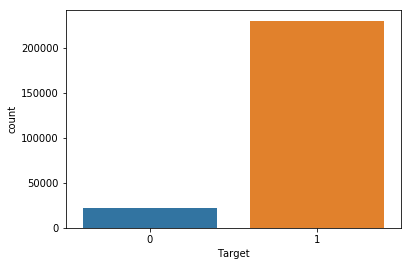

In [12]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()

### Heat map

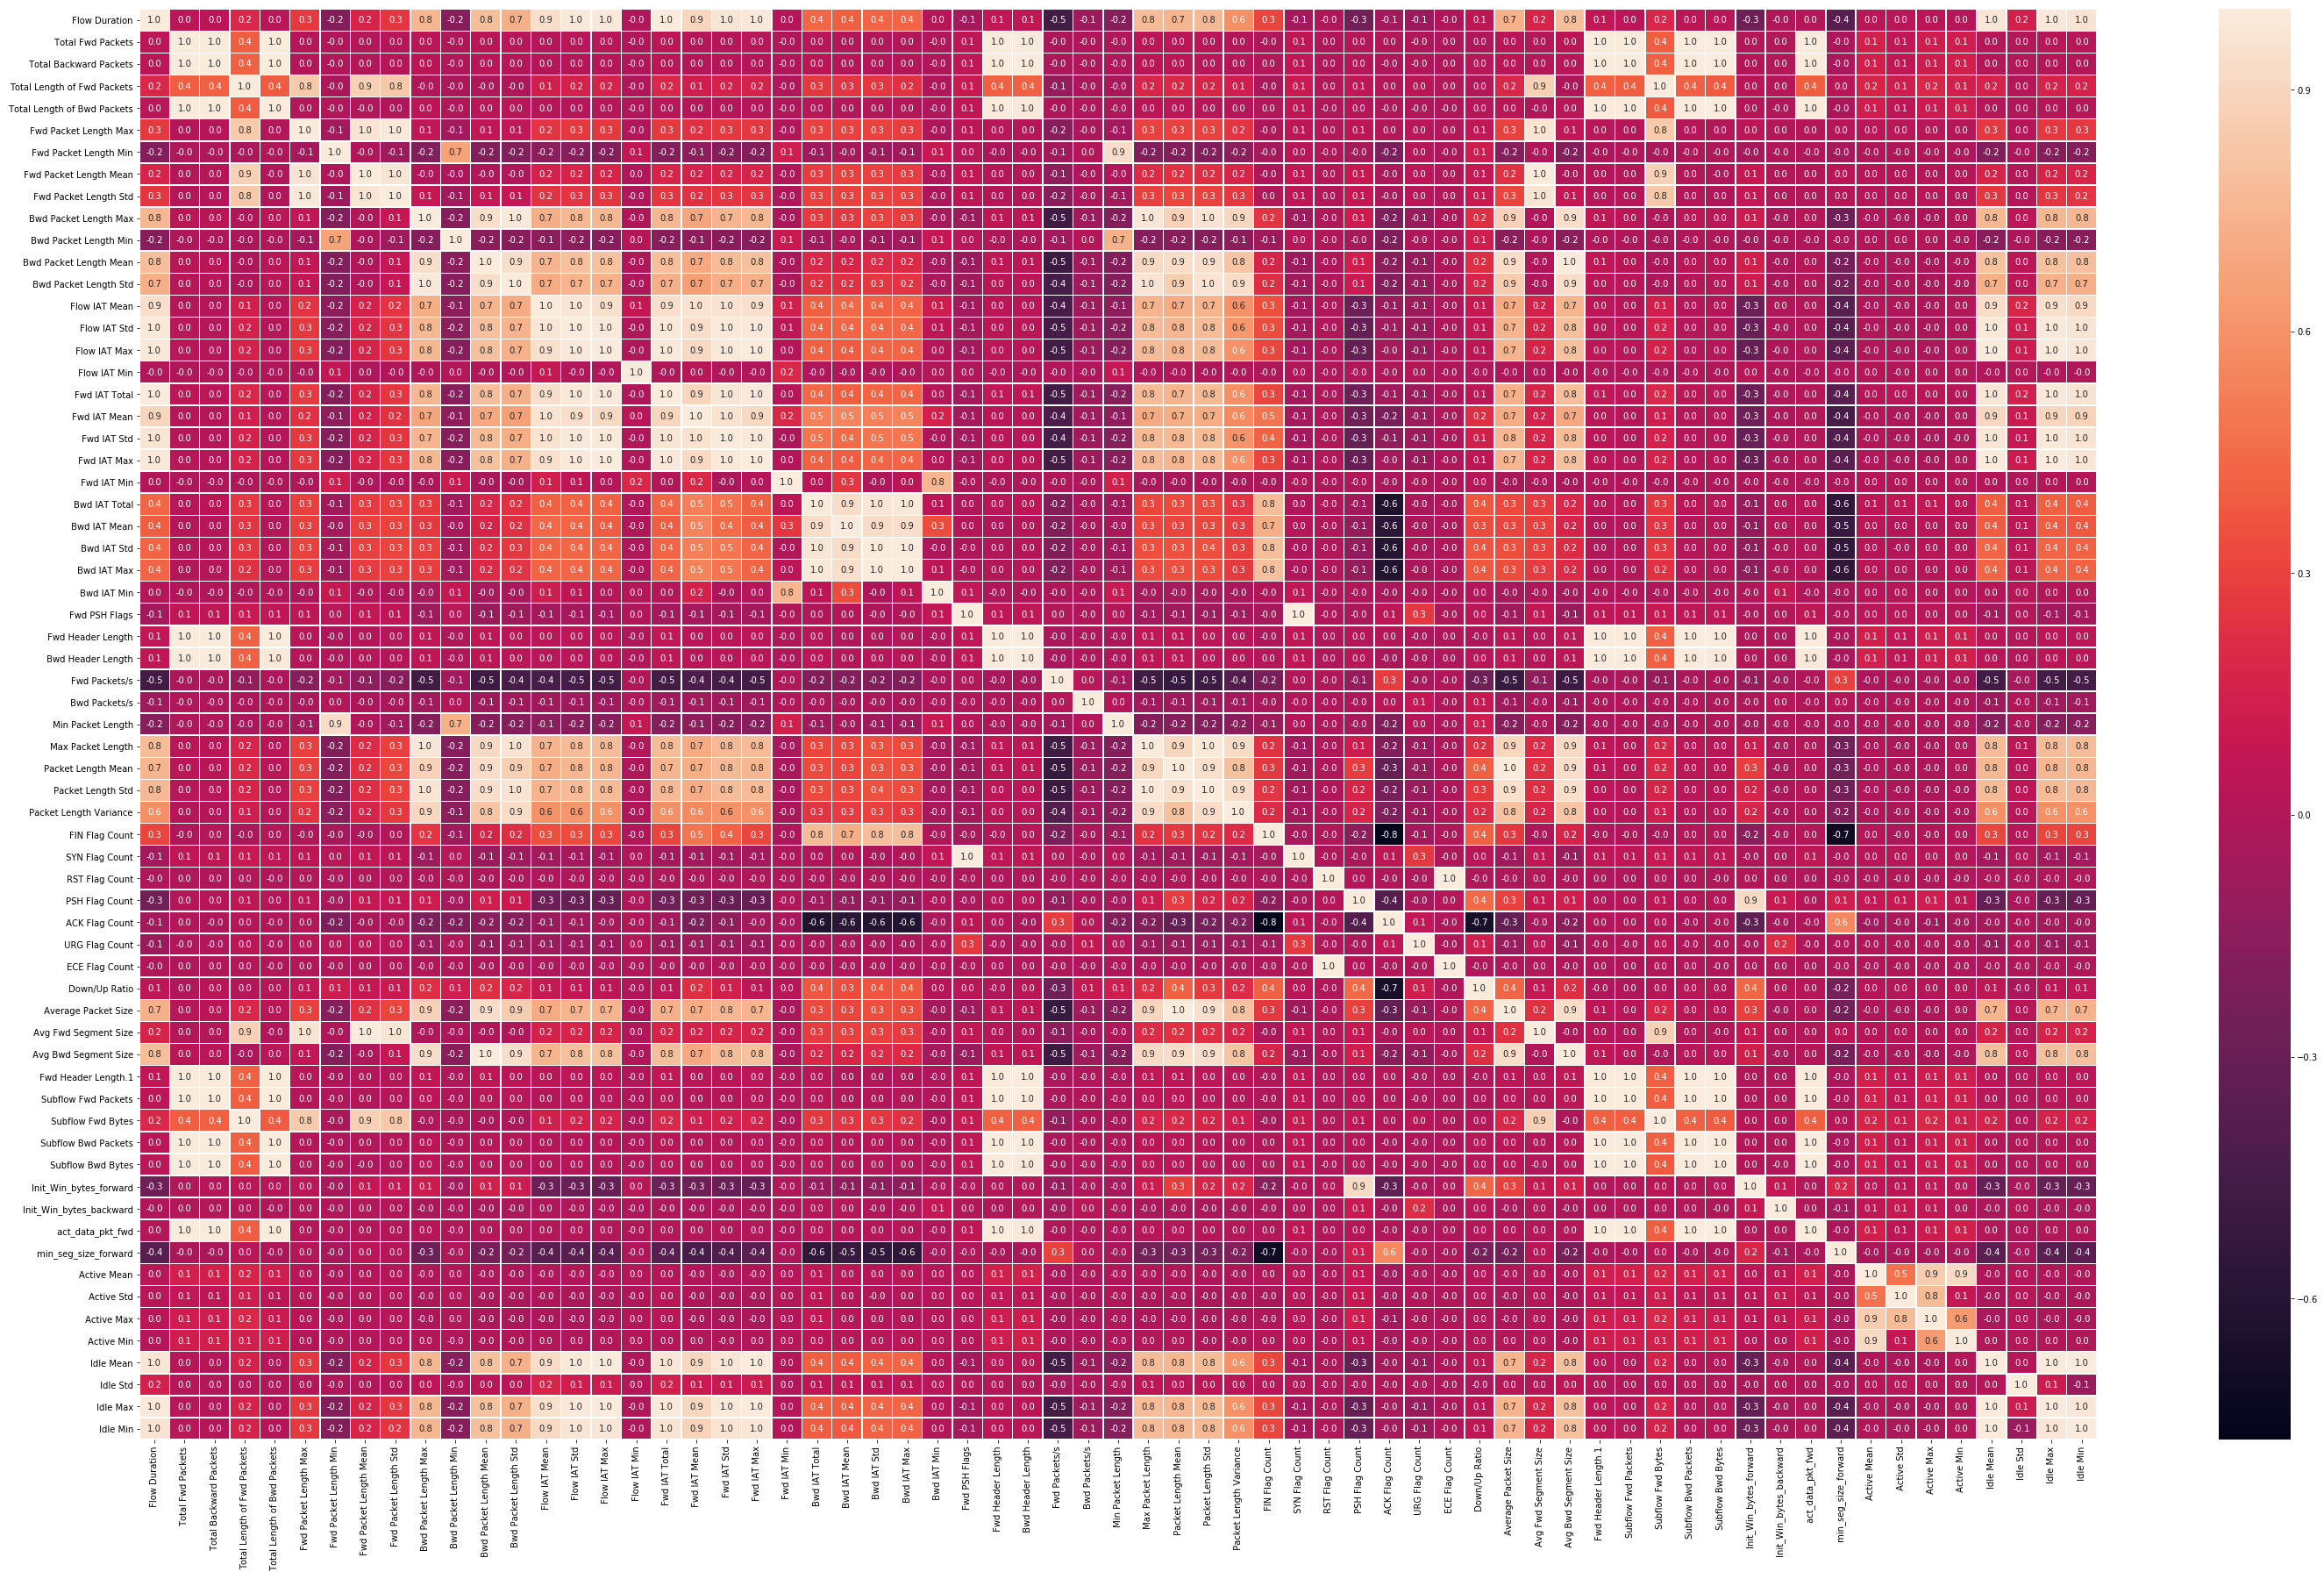

In [13]:
f, ax = plt.subplots(figsize=(50, 30))
sns_plot = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

In [14]:
sns_plot.figure.savefig("output_50_30_hulk.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 1 Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Recursice feature elimination with cross validation and random forest
     3.5 Tree based feature selection

## 3.1 High Correlation



In [15]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [16]:
upper

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,NaN,0.046348,0.038104,0.186794,0.034034,0.266859,0.184710,0.170990,0.253268,0.753385,...,0.022042,0.363498,0.024861,0.033670,0.040361,0.015310,0.978706,0.152337,0.988062,0.958755
Total Fwd Packets,NaN,NaN,0.995308,0.400343,0.998640,0.014823,0.009507,0.005461,0.008879,0.039366,...,0.998153,0.018293,0.147719,0.064953,0.127207,0.139862,0.026629,0.004823,0.026954,0.025951
Total Backward Packets,NaN,NaN,NaN,0.403946,0.993176,0.013734,0.005850,0.005684,0.008836,0.036512,...,0.994092,0.022034,0.146221,0.057727,0.121854,0.142534,0.019184,0.001675,0.019227,0.018869
Total Length of Fwd Packets,NaN,NaN,NaN,NaN,0.386635,0.845877,0.032234,0.872545,0.834130,0.006201,...,0.398363,0.030442,0.173836,0.126007,0.183901,0.147937,0.166428,0.012600,0.166702,0.164277
Total Length of Bwd Packets,NaN,NaN,NaN,NaN,NaN,0.005392,0.007175,0.002020,0.001260,0.038248,...,0.997745,0.017244,0.137456,0.051426,0.110756,0.134564,0.018070,0.001394,0.018088,0.017813
Fwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,0.054898,0.963070,0.992327,0.070466,...,0.011289,0.016948,0.023157,0.026926,0.032242,0.017082,0.261854,0.015601,0.261775,0.259077
Fwd Packet Length Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004285,0.069593,0.187498,...,0.001846,0.043859,0.003720,0.006036,0.006440,0.001954,0.183521,0.015634,0.183943,0.181119
Fwd Packet Length Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968310,0.005408,...,0.005901,0.041920,0.014643,0.017878,0.018407,0.009666,0.171019,0.006482,0.170611,0.169609
Fwd Packet Length Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080956,...,0.006508,0.016916,0.016943,0.020966,0.022660,0.011607,0.251993,0.012220,0.251644,0.249634
Bwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019976,0.273575,0.006597,0.023884,0.018827,0.002496,0.762260,0.048791,0.762283,0.754057


In [17]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

8
[' SYN Flag Count', ' ECE Flag Count', ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets']


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [18]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [19]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' Avg Bwd Segment Size', ' Bwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.4 Dropping features with 1 correlation

In [20]:
X_new = X.drop(X[to_drop], axis=1)

In [21]:
X_new.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318,4,0,64,0.0,46,6,16.0,20.00000,0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55718,1,2,0,0.0,0,0,0.0,0.00000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_new.isnull().sum().sum()

0

In [23]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [24]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [25]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

## 3.2 K-best

In [26]:
x_train, x_test, y_train, y_test = generate_data(X_new, y, 0, 42)
ranks = {}
y_train.value_counts()

1    229777
0     21839
Name: Target, dtype: int64

In [27]:
select_feature_5 = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

/home/chromares/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [28]:
print("Using f_classif with Kbest returns : \n")

print("5 Features : ", X_new.columns[select_feature_5.get_support(indices=True)])
print('\n')

Using f_classif with Kbest returns : 

5 Features :  Index([u'Total Length of Fwd Packets', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Bwd Packet Length Min',
       u' Min Packet Length'],
      dtype='object')




#### Data feature ranking on ANOVA F-based at 30% training data

In [29]:
scores = select_feature_5.scores_
scores  = [float(i) for i in scores]
features = X_new.columns
    
k_best_f_classif = zip(scores, features)

k_best_f_classif.sort(key= lambda x : x[0], reverse=True)
for element in k_best_f_classif:
    print(element[1].lstrip())

ranks["K-Best"] = ranking(scores, X_new.columns);

Min Packet Length
Bwd Packet Length Min
Fwd Packet Length Min
Fwd Packet Length Mean
Total Length of Fwd Packets
Bwd Packet Length Mean
Fwd Packet Length Max
Bwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Std
URG Flag Count
Packet Length Std
Fwd IAT Std
Idle Max
Idle Mean
Packet Length Mean
Fwd IAT Max
Flow IAT Max
Fwd PSH Flags
Idle Min
Max Packet Length
Average Packet Size
Flow IAT Std
Packet Length Variance
Flow IAT Mean
Fwd IAT Total
Fwd IAT Mean
Flow Duration
Init_Win_bytes_backward
FIN Flag Count
Down/Up Ratio
Active Max
Bwd Packets/s
PSH Flag Count
ACK Flag Count
Active Std
Active Mean
Fwd IAT Min
Init_Win_bytes_forward
Fwd Packets/s
Bwd IAT Min
Flow Packets/s
Active Min
Flow Bytes/s
Bwd IAT Mean
Bwd IAT Total
act_data_pkt_fwd
Total Backward Packets
Flow IAT Min
Total Fwd Packets
Bwd Header Length
min_seg_size_forward
Idle Std
Fwd Header Length
Total Length of Bwd Packets
Subflow Bwd Bytes
RST Flag Count
Bwd IAT Max
Bwd IAT Std


## 3.3 Recursive Feature Elimination using Random Forest

In [30]:
random_forest = RandomForestClassifier()      
rfe = RFE(estimator=random_forest, n_features_to_select=10, step=1)

In [31]:
rfe = rfe.fit(x_train, y_train.values)

In [32]:
print(rfe.support_)
print(len(rfe.support_))

[False False False False False  True False  True  True False  True False
 False False False False False False False False  True False False False
 False False False False False False  True False False False  True False
 False False False False False False False False False False False  True
  True False False False False  True False False False False False]
59


In [33]:
print('Chosen best 10 feature by rfe:', X_new.columns[rfe.support_])

rfe_features_correlated_10 = X_new.columns[rfe.support_]

Chosen best 10 feature by rfe: Index([u' Fwd Packet Length Max', u' Fwd Packet Length Mean',
       u' Fwd Packet Length Std', u' Bwd Packet Length Min', u' Fwd IAT Mean',
       u' Fwd Header Length', u' Min Packet Length', u'Init_Win_bytes_forward',
       u' Init_Win_bytes_backward', u' Active Max'],
      dtype='object')


In [35]:
scores = rfe.ranking_
scores  = [i for i in scores]
features = X_new.columns
    
rfe_rankings = zip(scores, features)

rfe_rankings.sort(key= lambda x : x[0])
for element in rfe_rankings:
    print(element)

(1, ' Total Length of Bwd Packets')
(1, ' Fwd Packet Length Mean')
(1, 'Flow Bytes/s')
(1, ' Flow Packets/s')
(1, ' Flow IAT Std')
(1, ' Fwd IAT Min')
(1, ' Bwd IAT Mean')
(1, ' Bwd Packets/s')
(1, ' Average Packet Size')
(1, ' Avg Bwd Segment Size')
(2, ' Fwd Packet Length Min')
(3, ' Max Packet Length')
(4, ' Flow IAT Min')
(5, ' Fwd Header Length')
(6, ' Bwd IAT Min')
(7, 'Fwd IAT Total')
(8, ' Packet Length Mean')
(9, ' Flow Duration')
(10, ' Init_Win_bytes_backward')
(11, 'Init_Win_bytes_forward')
(12, ' Flow IAT Max')
(13, ' Fwd Packet Length Max')
(14, ' Packet Length Std')
(15, ' Bwd Packet Length Mean')
(16, ' Fwd IAT Max')
(17, ' Packet Length Variance')
(18, 'Bwd Packet Length Max')
(19, ' Active Min')
(20, ' Bwd Header Length')
(21, ' Flow IAT Mean')
(22, ' Bwd IAT Max')
(23, ' ACK Flag Count')
(24, ' Fwd Packet Length Std')
(25, ' Fwd IAT Mean')
(26, 'Fwd PSH Flags')
(27, 'Total Length of Fwd Packets')
(28, ' Bwd Packet Length Std')
(29, ' Total Fwd Packets')
(30, ' Fwd IA

In [36]:
random_forest = RandomForestClassifier() 
rfe = RFE(estimator=random_forest, n_features_to_select=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [37]:
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), X_new.columns, order=-1)

In [38]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.45,
  ' Active Min': 0.0,
  ' Active Std': 0.52,
  ' Average Packet Size': 0.05,
  ' Avg Bwd Segment Size': 0.11,
  ' Bwd Header Length': 0.01,
  ' Bwd IAT Max': 1.0,
  ' Bwd IAT Mean': 0.98,
  ' Bwd IAT Min': 0.68,
  ' Bwd IAT Std': 0.48,
  ' Bwd Packet Length Mean': 0.11,
  ' Bwd Packet Length Min': 0.19,
  ' Bwd Packet Length Std': 0.06,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.13,
  ' Flow Duration': 0.47,
  ' Flow IAT Max': 0.91,
  ' Flow IAT Mean': 0.66,
  ' Flow IAT Min': 0.04,
  ' Flow IAT Std': 0.67,
  ' Flow Packets/s': 0.03,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.92,
  ' Fwd IAT Mean': 0.46,
  ' Fwd IAT Min': 0.35,
  ' Fwd IAT Std': 0.24,
  ' Fwd Packet Length Max': 0.01,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.06,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.77,
  ' Idle Min': 0.27,
  ' Idle Std': 0.47,
  ' Init_Win_bytes_backward': 0.01,
  ' Max Packet Length': 0.05,
  ' Mi

## 3.5 Recursive Feature Elimination with Corss Validation

In [39]:
clf_rf = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=10, scoring='accuracy')   #10-fold cross-validation
rfecv = rfecv.fit(x_train, y_train.values)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

Optimal number of features : 44
Best features : Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u'Bwd Packet Length Max',
       u' Bwd Packet Length Min', u' Bwd Packet Length Mean',
       u' Bwd Packet Length Std', u'Flow Bytes/s', u' Flow Packets/s',
       u' Flow IAT Mean', u' Flow IAT Std', u' Flow IAT Max', u' Flow IAT Min',
       u'Fwd IAT Total', u' Fwd IAT Mean', u' Fwd IAT Std', u' Fwd IAT Max',
       u' Fwd IAT Min', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd Header Length', u'Fwd Packets/s',
       u' Bwd Packets/s', u' Min Packet Length', u' Max Packet Length',
       u' Packet Length Mean', u' Packet Length Std',
       u' Packet Length Variance', u' URG Flag Count', u' Down/Up Ratio',
       u' Average Packet Size', u' Avg Bwd Segment

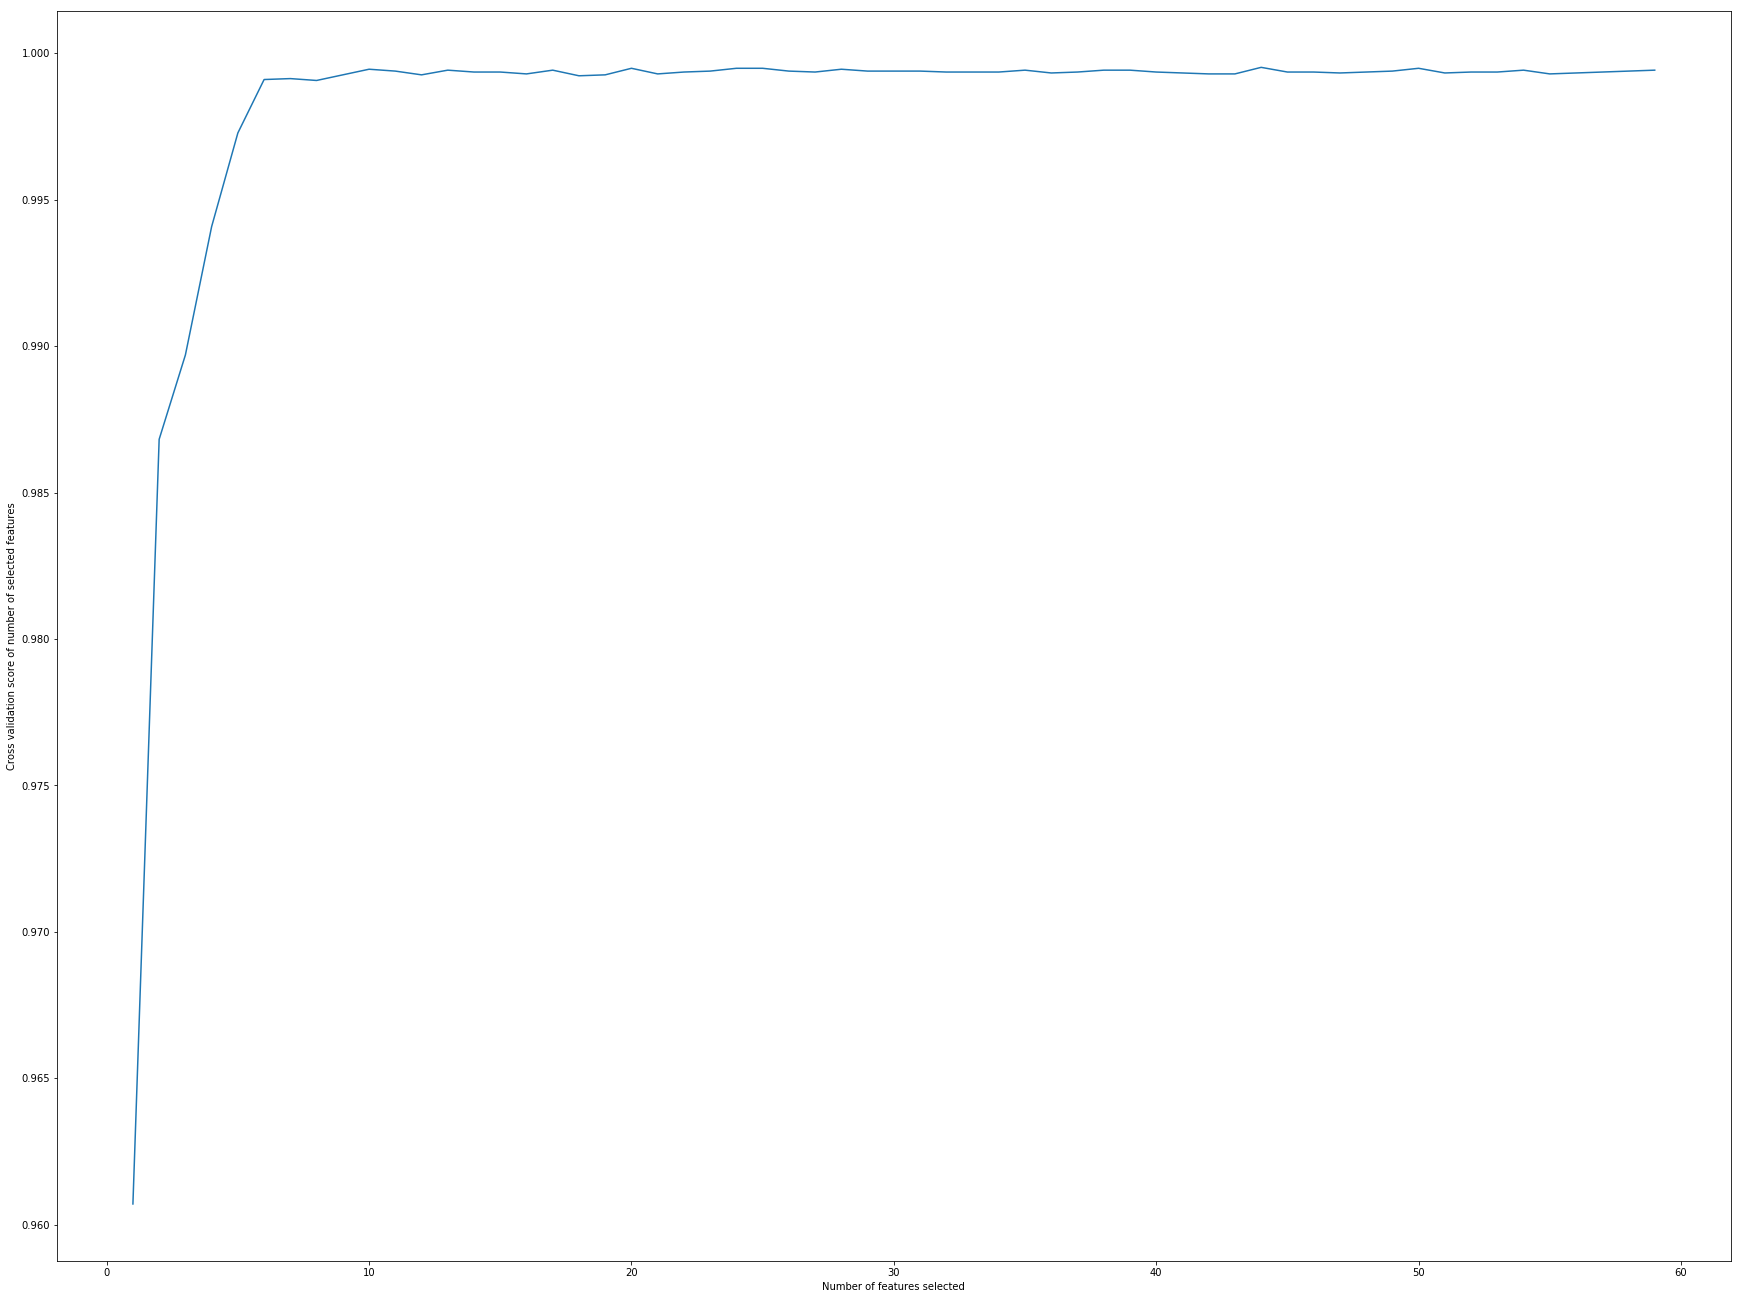

In [40]:
plt.figure(1, figsize=(30, 23))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig("REFCV_hulk_100.png")

In [41]:
for element in range(len(rfecv.grid_scores_)):
    print(element + 1, rfecv.grid_scores_[element])
    

1 0.960708533014173
2 0.9868191015832679
3 0.9896984055187872
4 0.9940813512344937
5 0.9972806960710345
6 0.9991042047213778
7 0.9991361740112051
8 0.9990721842479294
9 0.999264174011205
10 0.9994561125908594
11 0.9993921125908594
12 0.9992641330577545
13 0.9994241228275837
14 0.9993601228275839
15 0.9993601433010323
16 0.9992961330577546
17 0.9994241330643081
18 0.999232153531203
19 0.9992641535377567
20 0.9994881228275838
21 0.9992961228210303
22 0.9993601433010323
23 0.9993921330643081
24 0.9994881228275838
25 0.9994881023541353
26 0.9993921228210303
27 0.999360133064308
28 0.9994561330643081
29 0.9993921433010323
30 0.9993921228275839
31 0.9993921535377567
32 0.9993601433010323
33 0.9993601228275839
34 0.999360133064308
35 0.9994241330643081
36 0.9993281228275839
37 0.9993601433010323
38 0.9994241125908596
39 0.9994241125908596
40 0.9993601433010324
41 0.9993281330577546
42 0.9992961535377566
43 0.9992961740112051
44 0.9995201125908595
45 0.9993601535377566
46 0.9993601535377566
47

In [42]:
print(rfecv.grid_scores_[-52]) #8
print(rfecv.grid_scores_[-35]) #25
print(rfecv.grid_scores_[-46]) #14
print(X_new.shape)

print(rfecv.grid_scores_[-32]) #28
print(rfecv.grid_scores_[-45]) #15


0.9990721842479294
0.9994881023541353
0.9993601228275839
(31254, 59)
0.9994561330643081
0.9993601433010323


### Tree based feature selecion

In [43]:
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(x_train, y_train.values)
importances = clr_rf.feature_importances_

In [44]:
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ranking_tree_based = []
for f in range(x_train.shape[1]):
    print(f + 1, features[indices[f]])
    ranking_tree_based.append(features[indices[f]])

ranking_tree_zip = zip(features[indices], importances[indices])
ranking_tree_zip.sort(key= lambda x : x[1], reverse=True)

for element in ranking_tree_zip:
    print(element[1])
    
ranks["RF"] = ranking(clf_rf.feature_importances_, X_new.columns)

Feature ranking:
1  Bwd IAT Mean
2  Flow Packets/s
3  Avg Bwd Segment Size
4  Flow IAT Min
5  Fwd IAT Mean
6  Fwd IAT Max
7 Flow Bytes/s
8  Total Backward Packets
9  Fwd IAT Min
10  Max Packet Length
11  min_seg_size_forward
12  Idle Max
13  Bwd Packets/s
14  Packet Length Variance
15  Flow IAT Std
16  Fwd Packet Length Mean
17  Fwd Header Length
18  Packet Length Mean
19  Min Packet Length
20  Bwd Packet Length Mean
21  Fwd Packet Length Max
22 Fwd Packets/s
23 Fwd PSH Flags
24  Active Min
25  Packet Length Std
26  Total Fwd Packets
27  PSH Flag Count
28 Fwd IAT Total
29  Fwd IAT Std
30  Bwd Header Length
31  Init_Win_bytes_backward
32 Total Length of Fwd Packets
33  Bwd IAT Max
34 Bwd Packet Length Max
35 Bwd IAT Total
36  Bwd IAT Min
37  Flow Duration
38  Down/Up Ratio
39  Average Packet Size
40  Fwd Packet Length Std
41  Total Length of Bwd Packets
42  Active Max
43 Init_Win_bytes_forward
44 Idle Mean
45  Fwd Packet Length Min
46 Active Mean
47  Flow IAT Mean
48  Bwd IAT Std
49  Fl

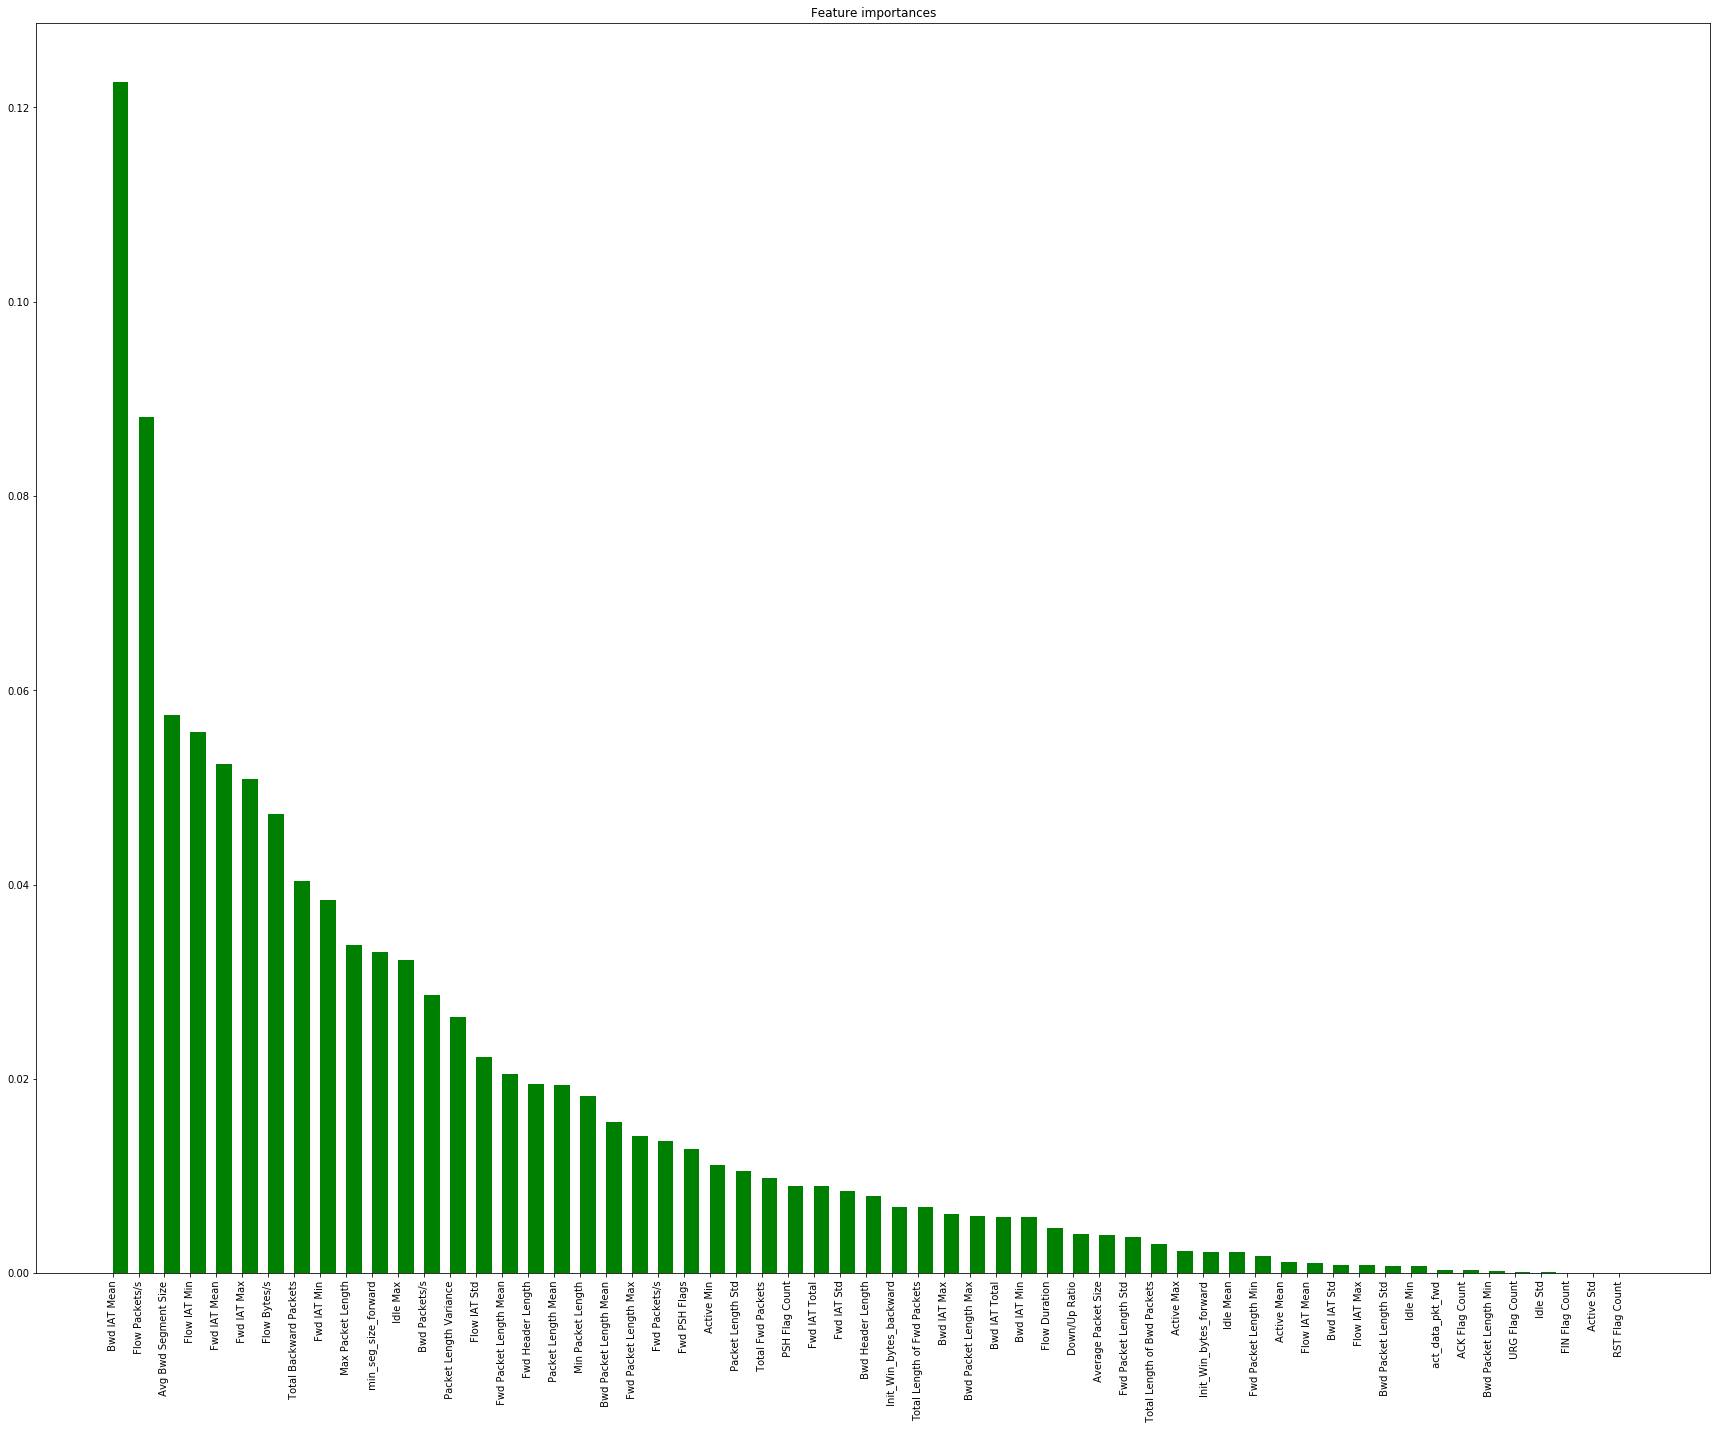

In [45]:
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], 0.6,
       color="g", align="edge")
plt.xticks(range(x_train.shape[1]), X_new.columns[indices],rotation=90)
plt.savefig("rf_features_hulk_100.png")

## PCA

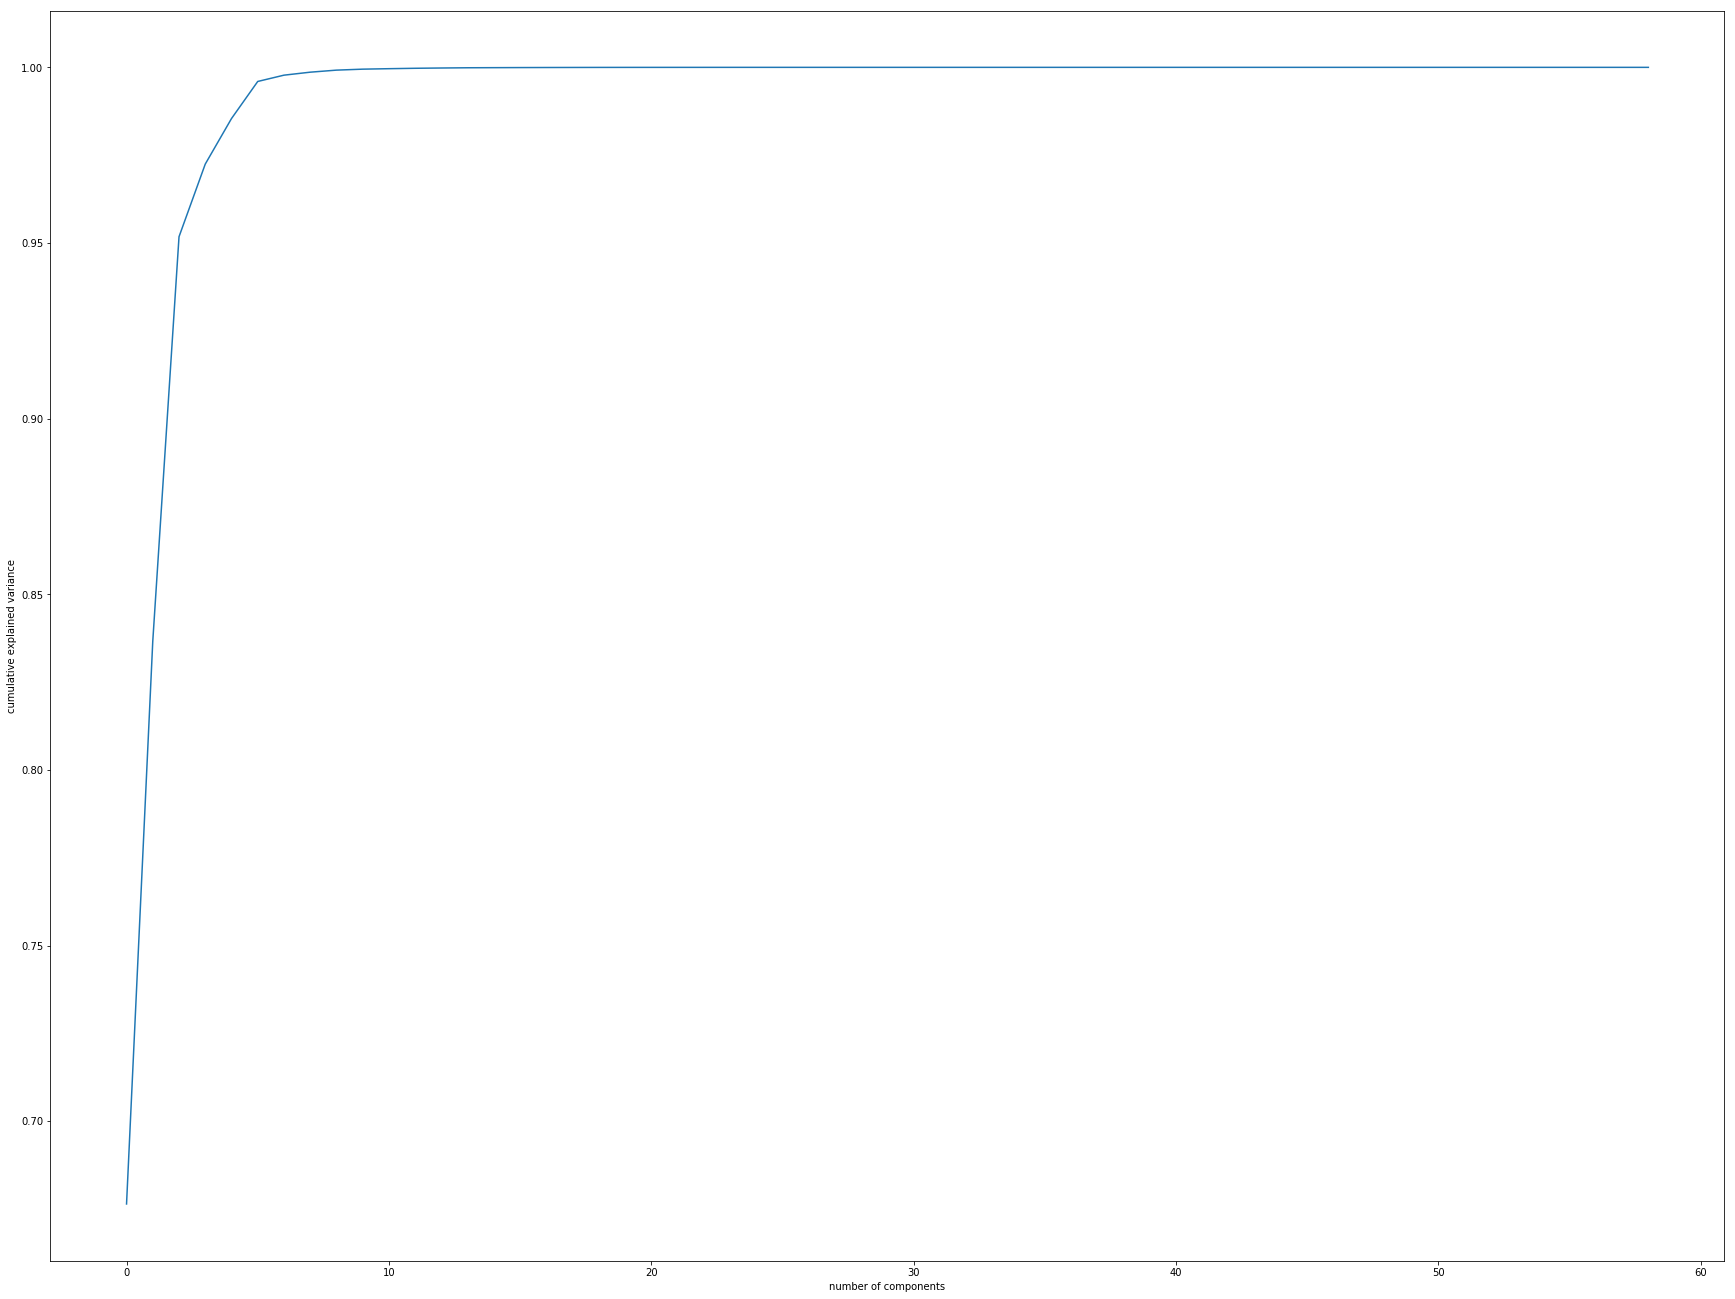

In [46]:
x_train_N = (x_train - x_train.mean())/(x_train.max() - x_train.min())
#x_test_N = (x_test - x_test.mean())/(x_test.max() - x_test.min())

pca = PCA().fit(x_train_N)
plt.figure(1, figsize=(30, 23))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig("pca_cumulative_hulk_100.png")

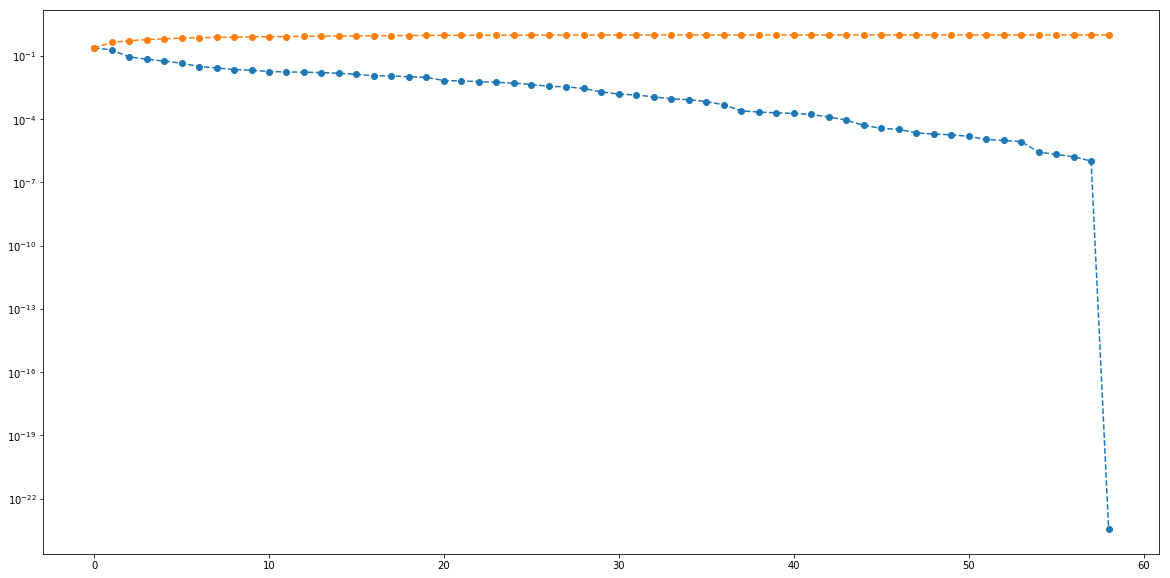

In [47]:
z_scaler = StandardScaler()

z_data = z_scaler.fit_transform(x_train)
pca_trafo = PCA().fit(z_data);

plt.figure(figsize=(20,10))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o');
plt.savefig("pca_cumulative_individual_100_hulk.png")

In [48]:
variance = [0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.85, 0.80]
print("Original shape:   ", x_train.shape)

for i in variance:
    pca_var = PCA(i)
    pca_var.fit(x_train)
    x_var = pca_var.transform(x_train_N)
    print("Transformed shape for variance " + str(i) + " is ", x_var.shape)
    

Original shape:    (31254, 59)
Transformed shape for variance 0.999 is  (31254, 9)
Transformed shape for variance 0.99 is  (31254, 6)
Transformed shape for variance 0.98 is  (31254, 5)
Transformed shape for variance 0.97 is  (31254, 4)
Transformed shape for variance 0.96 is  (31254, 4)
Transformed shape for variance 0.95 is  (31254, 3)
Transformed shape for variance 0.9 is  (31254, 3)
Transformed shape for variance 0.85 is  (31254, 3)
Transformed shape for variance 0.8 is  (31254, 2)


## Summary

### 1. Eliminate features with 0 variance
### 2. Eliminate features with 1 correlation
### 3. Estimate feature rankings (various data set sizes) with
        K best
        Recursive feature elimination
        Recursive feature elimination with cross validation
        Random Forest
### 4. Apply PCA just to check how variance is distributed
### 5. Make a classifier with PCA and check accuracy, this will be ML solution for hulk
### 6. Find minimal set of features for rule generation with highest accuracy
### 7. Generate rules

## Obtained Feature rankings

### 1.0 100% Split

In [49]:
print("RFECV at 100% train:")
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

RFECV at 100% train:
Optimal number of features : 44
Best features : Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u'Bwd Packet Length Max',
       u' Bwd Packet Length Min', u' Bwd Packet Length Mean',
       u' Bwd Packet Length Std', u'Flow Bytes/s', u' Flow Packets/s',
       u' Flow IAT Mean', u' Flow IAT Std', u' Flow IAT Max', u' Flow IAT Min',
       u'Fwd IAT Total', u' Fwd IAT Mean', u' Fwd IAT Std', u' Fwd IAT Max',
       u' Fwd IAT Min', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd Header Length', u'Fwd Packets/s',
       u' Bwd Packets/s', u' Min Packet Length', u' Max Packet Length',
       u' Packet Length Mean', u' Packet Length Std',
       u' Packet Length Variance', u' URG Flag Count', u' Down/Up Ratio',
       u' Average Packet Size

In [50]:
#rfecv.score(x_test, y_test)

In [51]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.45,
  ' Active Min': 0.0,
  ' Active Std': 0.52,
  ' Average Packet Size': 0.05,
  ' Avg Bwd Segment Size': 0.11,
  ' Bwd Header Length': 0.01,
  ' Bwd IAT Max': 1.0,
  ' Bwd IAT Mean': 0.98,
  ' Bwd IAT Min': 0.68,
  ' Bwd IAT Std': 0.48,
  ' Bwd Packet Length Mean': 0.11,
  ' Bwd Packet Length Min': 0.19,
  ' Bwd Packet Length Std': 0.06,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.13,
  ' Flow Duration': 0.47,
  ' Flow IAT Max': 0.91,
  ' Flow IAT Mean': 0.66,
  ' Flow IAT Min': 0.04,
  ' Flow IAT Std': 0.67,
  ' Flow Packets/s': 0.03,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.92,
  ' Fwd IAT Mean': 0.46,
  ' Fwd IAT Min': 0.35,
  ' Fwd IAT Std': 0.24,
  ' Fwd Packet Length Max': 0.01,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.06,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.77,
  ' Idle Min': 0.27,
  ' Idle Std': 0.47,
  ' Init_Win_bytes_backward': 0.01,
  ' Max Packet Length': 0.05,
  ' Mi

In [52]:
r = {}
for name in X_new.columns:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t\t\t\t%s" % "\t".join(methods))
for name in X_new.columns:
    print("%s\t\t\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))


				K-Best	RF	RFE	Mean
 Flow Duration			0.47	0.04	0.57	0.36
 Total Fwd Packets			0.0	0.08	0.28	0.12
 Total Backward Packets			0.0	0.33	0.38	0.24
Total Length of Fwd Packets			0.0	0.06	0.78	0.28
 Total Length of Bwd Packets			0.0	0.02	0.76	0.26
 Fwd Packet Length Max			0.01	0.12	0.62	0.25
 Fwd Packet Length Min			0.06	0.01	0.55	0.21
 Fwd Packet Length Mean			0.01	0.17	0.5	0.23
 Fwd Packet Length Std			0.0	0.03	0.34	0.12
Bwd Packet Length Max			0.08	0.05	0.72	0.28
 Bwd Packet Length Min			0.19	0.0	0.4	0.2
 Bwd Packet Length Mean			0.11	0.13	0.98	0.41
 Bwd Packet Length Std			0.06	0.01	0.21	0.09
Flow Bytes/s			0.01	0.39	0.67	0.36
 Flow Packets/s			0.03	0.72	0.53	0.43
 Flow IAT Mean			0.66	0.01	1.0	0.56
 Flow IAT Std			0.67	0.18	0.95	0.6
 Flow IAT Max			0.91	0.01	0.74	0.55
 Flow IAT Min			0.04	0.45	0.6	0.36
Fwd IAT Total			0.48	0.07	0.71	0.42
 Fwd IAT Mean			0.46	0.43	0.79	0.56
 Fwd IAT Std			0.24	0.07	0.31	0.21
 Fwd IAT Max			0.92	0.42	0.93	0.76
 Fwd IAT Min			0.35	0.31	0.69	0.45
Bwd IAT 

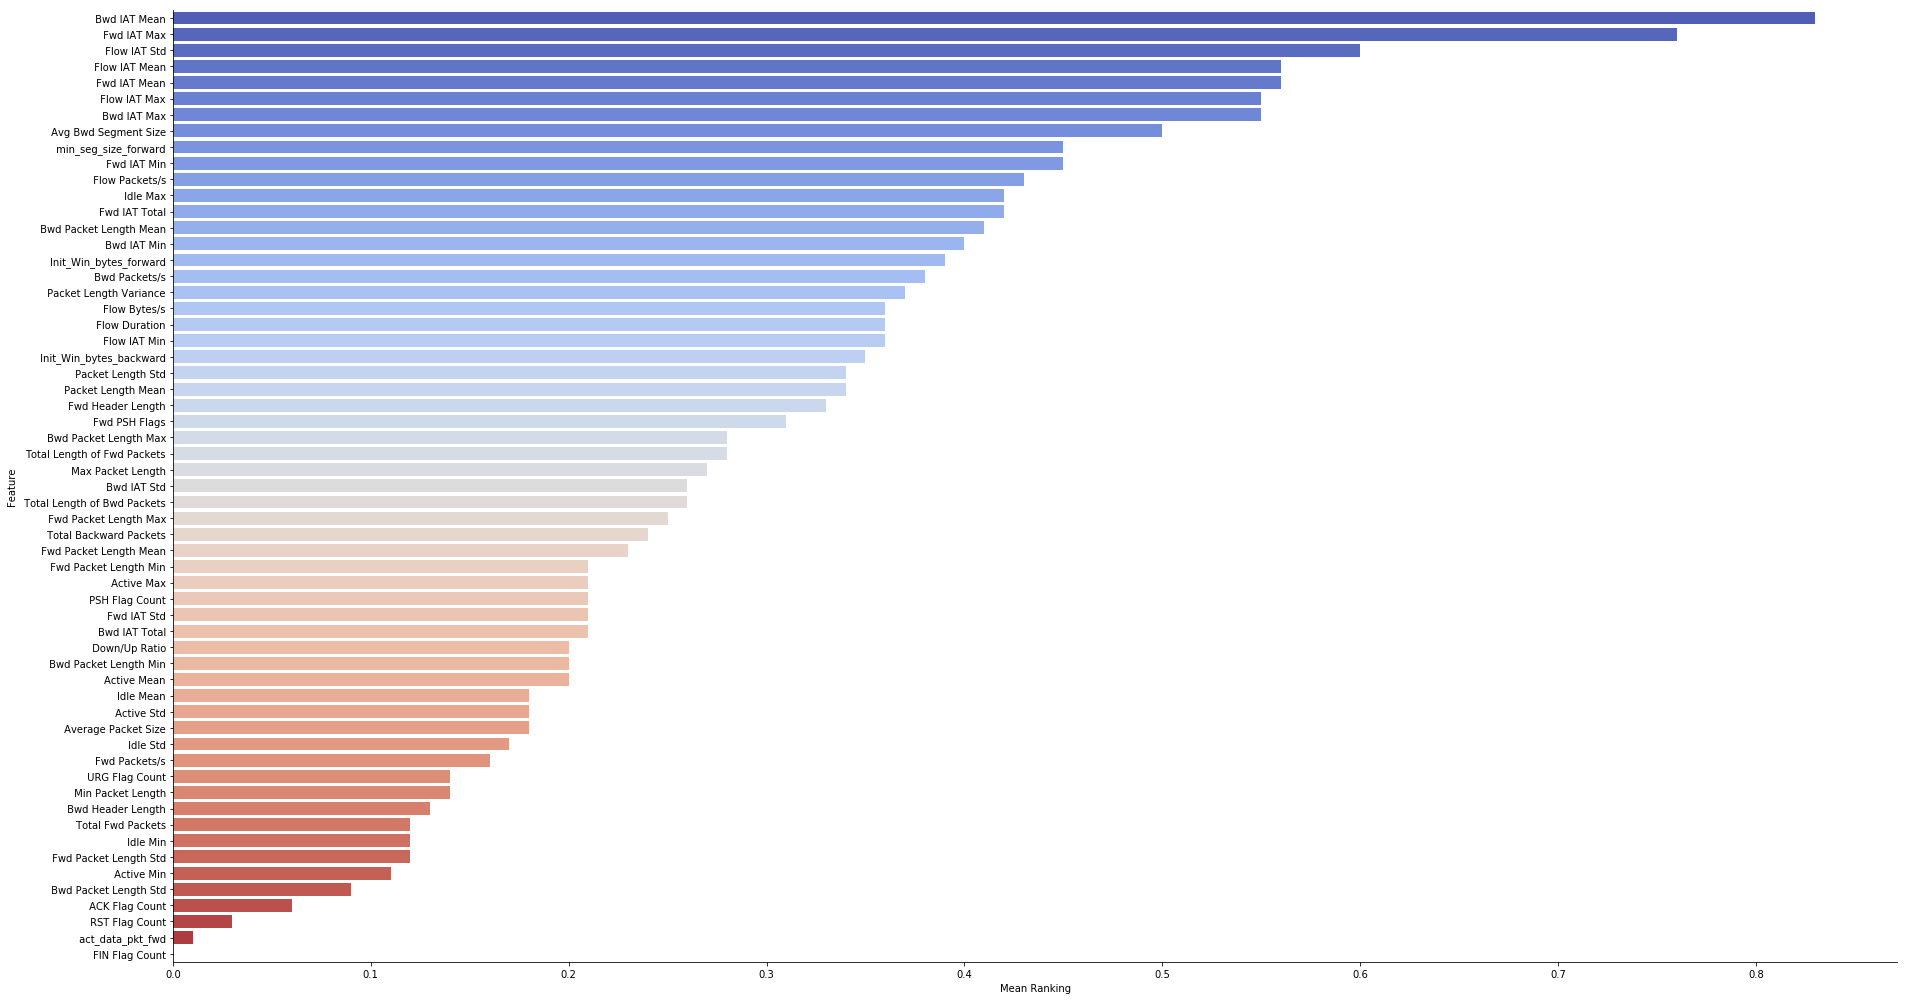

In [53]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
y2k = sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')
y2k.savefig("mean_ranking_100_hulk.png")

In [54]:
meanplot

,Feature,Mean Ranking
10,Bwd IAT Mean,0.83
50,Fwd IAT Max,0.76
29,Flow IAT Std,0.60
35,Flow IAT Mean,0.56
26,Fwd IAT Mean,0.56
38,Flow IAT Max,0.55
37,Bwd IAT Max,0.55
18,Avg Bwd Segment Size,0.50
30,min_seg_size_forward,0.45
41,Fwd IAT Min,0.45


## Testing

### Three highest grid scores were obtained at 8, 14 and 25 features. So we use these

In [79]:
#YOU CAN GENERATE DIFFERENT TRAINING SAMPLES HERE at #here. x_train, y_train is 70% by default. 

### RFE

In [80]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-------------------------------------------------------")
    random_forest = RandomForestClassifier()      
    rfe = RFE(estimator=random_forest, n_features_to_select=i, step=1)
    rfe = rfe.fit(x_train, y_train)
    print("RFE features at size " + str(i) + " are \n\n")
    #here
    for el in X_new.columns[rfe.support_]:
        print(el.lstrip())
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on x%
        training_x = rfe.transform(training_x)
        testing_x = rfe.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)

        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)

    

RFE features at size 4 are 


Flow Packets/s
Flow IAT Mean
Average Packet Size
Init_Win_bytes_backward


0    22926
1     5202
Name: Target, dtype: int64
(28128, 4)
Accuracy at 0.1 for 4 is:  0.9987204094689699


0    20408
1     4595
Name: Target, dtype: int64
(25003, 4)
Accuracy at 0.2 for 4 is:  0.9987202047672372


0    17849
1     4028
Name: Target, dtype: int64
(21877, 4)
Accuracy at 0.3 for 4 is:  0.9986136290924603


0    15314
1     3438
Name: Target, dtype: int64
(18752, 4)
Accuracy at 0.4 for 4 is:  0.9984802431610942


0    12744
1     2883
Name: Target, dtype: int64
(15627, 4)
Accuracy at 0.5 for 4 is:  0.9987201638190312


0    10187
1     2314
Name: Target, dtype: int64
(12501, 4)
Accuracy at 0.6 for 4 is:  0.9984535807604117


0    7632
1    1744
Name: Target, dtype: int64
(9376, 4)
Accuracy at 0.7 for 4 is:  0.9985830514672274


0    5093
1    1157
Name: Target, dtype: int64
(6250, 4)
Accuracy at 0.8 for 4 is:  0.9975203967365222


0    2556
1     569
Name: Target, dty

### K Best

In [81]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-----------------------------------------")
    select_feature = SelectKBest(f_classif, k=i).fit(x_train, y_train)
    print("Top " + str(i) + " features :", X_new.columns[select_feature.get_support(indices=True)])
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on 70%
    
        training_x = select_feature.transform(training_x)
        testing_x = select_feature.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)
    
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)


Top 4 features : Index([u' Flow IAT Max', u' Fwd IAT Max', u' Bwd IAT Mean', u' Bwd IAT Max'], dtype='object')


0    22926
1     5202
Name: Target, dtype: int64
(28128, 4)
Accuracy at 0.1 for 4 is:  0.9817658349328215


0    20408
1     4595
Name: Target, dtype: int64
(25003, 4)
Accuracy at 0.2 for 4 is:  0.9792033274676052


0    17849
1     4028
Name: Target, dtype: int64
(21877, 4)
Accuracy at 0.3 for 4 is:  0.9761117628239309


0    15314
1     3438
Name: Target, dtype: int64
(18752, 4)
Accuracy at 0.4 for 4 is:  0.9756039033754599


0    12744
1     2883
Name: Target, dtype: int64
(15627, 4)
Accuracy at 0.5 for 4 is:  0.9768989569335125


0    10187
1     2314
Name: Target, dtype: int64
(12501, 4)
Accuracy at 0.6 for 4 is:  0.9748306937556658


0    7632
1    1744
Name: Target, dtype: int64
(9376, 4)
Accuracy at 0.7 for 4 is:  0.973992138221044


0    5093
1    1157
Name: Target, dtype: int64
(6250, 4)
Accuracy at 0.8 for 4 is:  0.9728443449048152


0    2556
1     569
Name: Targ

### Tree based

In [56]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-------------------------")
    features_selected = ranking_tree_based[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1, 0.2]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-------------------------
[' Bwd IAT Mean', ' Flow Packets/s', ' Avg Bwd Segment Size', ' Flow IAT Min']
(31254, 4)
Accuracy at 0.1 for 4 is:  0.9798464491362764
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2540
          1       0.96      0.93      0.95       586

avg / total       0.98      0.98      0.98      3126

Accuracy at 0.2 for 4 is:  0.9816029435290353
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      5058
          1       0.98      0.92      0.95      1193

avg / total       0.98      0.98      0.98      6251


-------------------------
[' Bwd IAT Mean', ' Flow Packets/s', ' Avg Bwd Segment Size', ' Flow IAT Min', ' Fwd IAT Mean']
(31254, 5)
Accuracy at 0.1 for 5 is:  0.981445937300064
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2540
          1       0.96      0.95      0.95       586

avg / total       0.9